## Data analysis with SQL, Python (Pandas and Matplotlib)

Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
import warnings
warnings.filterwarnings("ignore")

Load and clean data

In [2]:
storeco = pd.read_csv("storeco_data.csv")
storeco.columns = storeco.columns.str.strip()

In [3]:
storeco.head()

,dateordered,datereturned,orderstatus,orders
0,12/31/16,1/24/17,returned,1
1,12/31/16,NaN,complete,8
2,12/30/16,NaN,complete,14
3,12/29/16,NaN,complete,14
4,12/28/16,12/29/16,returned,1


In [4]:
storeco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dateordered   213 non-null    object
 1   datereturned  60 non-null     object
 2   orderstatus   213 non-null    object
 3   orders        213 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.8+ KB


DateTime adjustments

In [5]:
storeco['dateordered'] =  pd.to_datetime(storeco['dateordered'],format='%m/%d/%y')
storeco['datereturned'] =  pd.to_datetime(storeco['datereturned'],format='%m/%d/%y')

In [6]:
storeco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dateordered   213 non-null    datetime64[ns]
 1   datereturned  60 non-null     datetime64[ns]
 2   orderstatus   213 non-null    object        
 3   orders        213 non-null    int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 6.8+ KB


In [7]:
storeco.head()

,dateordered,datereturned,orderstatus,orders
0,2016-12-31,2017-01-24,returned,1
1,2016-12-31,NaT,complete,8
2,2016-12-30,NaT,complete,14
3,2016-12-29,NaT,complete,14
4,2016-12-28,2016-12-29,returned,1


Load data to SQL

In [8]:
conn = sql.connect("storeco.db")
storeco.to_sql("storeco",conn,if_exists='replace',index=False)

213

Task 1: Crunch the data and determine whether the return rate is trending up or down.
- Step 1: Aggregate the data
- Step 2: Create a visualization

In [9]:
# Query
query = """          
    SELECT 
        strftime('%Y-%m', dateordered) AS 'Order Month',
        SUM(orders) AS 'Total Orders',
        SUM(CASE WHEN orderstatus = 'returned' THEN 0 ELSE orders END) AS 'Completed Orders',
        SUM(CASE WHEN orderstatus = 'complete' THEN 0 ELSE orders END) AS 'Returned Orders',
        100*round(SUM(CASE WHEN orderstatus = 'complete' THEN 0 ELSE orders END)/((SUM(orders))*1.00),4) AS 'Return Percentage'
    FROM storeco 
    GROUP BY 1
    ORDER BY 1 ASC;               
"""
result = pd.read_sql_query(query, conn)
result

,Order Month,Total Orders,Completed Orders,Returned Orders,Return Percentage
0,2016-08,149,139,10,6.71
1,2016-09,143,134,9,6.29
2,2016-10,180,170,10,5.56
3,2016-11,226,214,12,5.31
4,2016-12,395,376,19,4.81


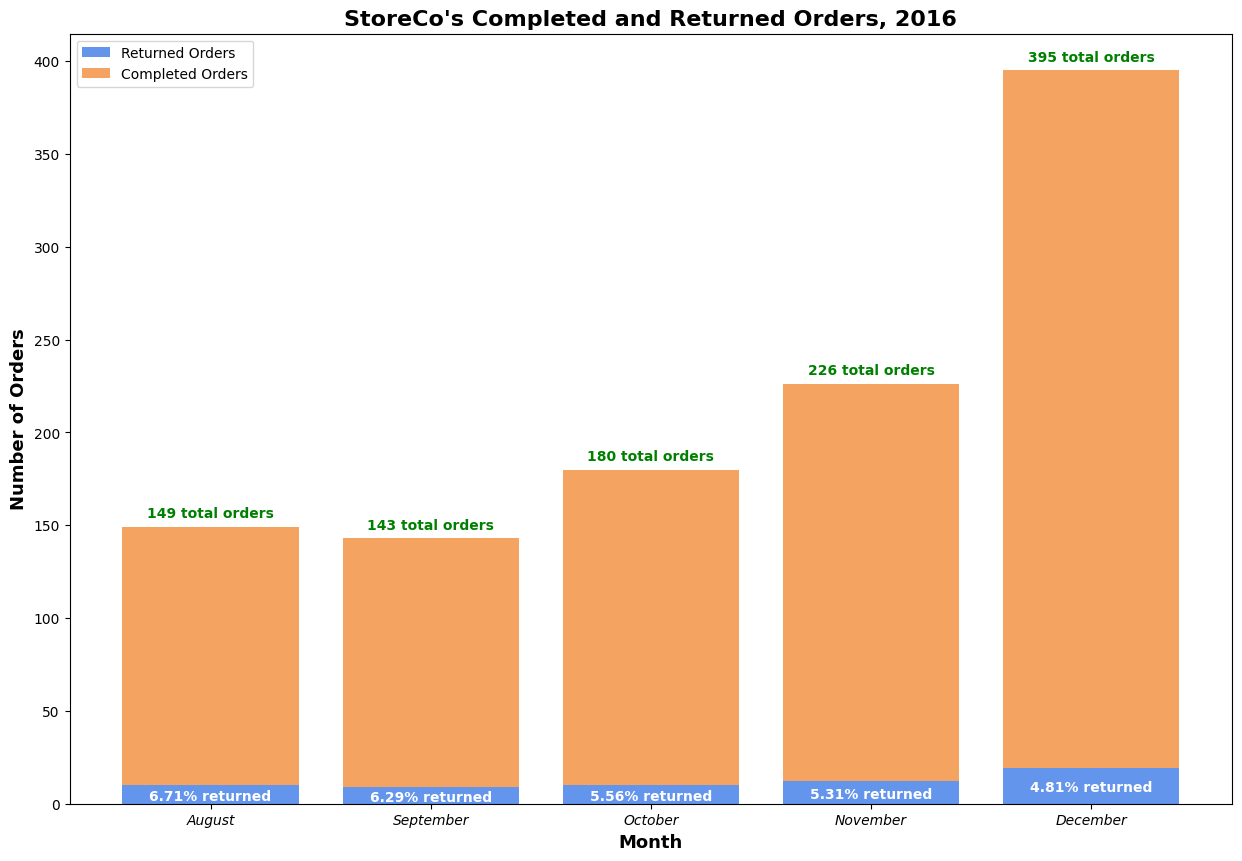

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))

returns = result['Returned Orders']
completed = result['Completed Orders']
total = result['Total Orders']
percent = result['Return Percentage']

p1 = plt.bar(range(len(returns)),
 returns, color = 'cornflowerblue')

p2 = plt.bar(range(len(completed)),
 completed, bottom = returns, color = 'sandybrown')


ax.set_xticklabels(['0','August', 'September', 'October','November', 'December'], style='italic')
plt.xlabel("Month", fontweight='bold', fontsize = 13)
plt.ylabel("Number of Orders", fontweight='bold', fontsize = 13)
plt.legend((p1[0], p2[0]), ('Returned Orders', 'Completed Orders'))
plt.title("StoreCo's Completed and Returned Orders, 2016", fontsize = 16, fontweight = 'bold')

for a,b in zip(range(len(total)), total): 
   plt.text(a, b+5, str(b)+" total orders", horizontalalignment='center', color='green', fontweight='bold')

for a,b,c  in zip(range(len(percent)), percent, returns): #use percent as the text, and returns as the height
   plt.text(a, c/2-4+1, str(round(b,2))+"% returned", horizontalalignment='center', color='white', fontweight='bold')

plt.savefig('completed_and_returned_orders_trend.png')
plt.show()

Additional insight: The return rate is going down because completed orders are increasing. The absolute number of returns is staying steady. So we may want to look at why we can't get returns to be any lower (this could be a policy or disclosure change with the customer). Further, please note that in the data set, returns never go higher than one per day.